# Sea ice plots

Run with 14 CPUs.

See https://github.com/pedrocol/basal_mom5-collaborative-project/issues?q=is%3Aissue+sea+ice

especially

https://github.com/pedrocol/basal_mom5-collaborative-project/issues/64

https://github.com/pedrocol/basal_mom5-collaborative-project/issues/33

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
#import xgcm
from datetime import timedelta
import calendar

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

# figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
import xesmf
import os
import pandas as pd
from datetime import datetime
from tqdm import tqdm_notebook

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33309/status,
Dashboard: /proxy/33309/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35289,Workers: 7
Dashboard: /proxy/33309/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:44425,Total threads: 2
Dashboard: /proxy/35629/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:46117,


## Set experiments to analyse
see https://github.com/pedrocol/basal_mom5-collaborative-project#new-simulations-use-these-ones

### Control

In [4]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
control_session = cc.database.create_session(session_name)

control = '01deg_jra55v13_ryf9091_DSW'

### Perturbations

GPC029 (Basal) `01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb` : Tbasal equal Tinsitu, calving flux inserted at the surface as runoff

GPC023 (Basal_LH) `01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb` : Tbasal based on Gade line, calving flux inserted at the surface as runoff

GPC062 (Basal_LH_Brine) `01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine` : Tbasal based on Gade line, calving flux inserted at the surface as runoff, brine param.

`session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'`

In [5]:
session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

perturbations = {
                    'Basal': '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb',  # GPC029
                    'Basal_LH': '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb',  # GPC023
                    # 'Basal_LH_YesIcb': '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb',  # GPC026
                    'Basal_LH_Brine': '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine',  # GPC062
                }

In [6]:
styles = { # defines line plot order, legend labels (keys) and keyword args (dicts)
    'Obs':            {'color':'grey',      'linestyle':'-',  'linewidth':3},
    'Control':        {'color':"#000000",   'linestyle':'-',  'linewidth':3},
    'Basal':          {'color':"#DDAA33",   'linestyle':'--', 'linewidth':2},
    'Basal_LH':      {'color':"#BB5566",   'linestyle':'--', 'linewidth':2},
    'Basal_LH_Brine': {'color':"steelblue", 'linestyle':'-',  'linewidth':2},
}

In [7]:
runs = { 'Control': control, **perturbations }
sessions = { 'Control': control_session, **{k:basal_melt_session for k in perturbations} }

In [8]:
runs

{'Control': '01deg_jra55v13_ryf9091_DSW',
 'Basal': '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb',
 'Basal_LH': '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb',
 'Basal_LH_Brine': '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine'}

In [9]:
cc.querying.get_experiments(basal_melt_session)

,experiment,ncfiles
0,01deg_jra55v13_ryf9091_DSW_control_mwp,91
1,01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb,1060
2,01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb,1454
3,01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb_mwp,116
4,01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb,1480
5,accessom2-GPC038,408
6,accessom2-GPC039,499
7,accessom2-GPC034,14
8,accessom2-GPC035,22
9,accessom2-GPC036,22


In [10]:
lat_slice = slice(-90,-59)
# lon_slice = slice(-280,80)

fontsize=15

In [11]:
# Month labels
monthnames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [12]:
# print the time range for each experiment - NB: includes CICE date offset, fixed in fixcoords below
for k, expt in runs.items():
    print(k, expt)
    t1 = cc.querying.getvar(expt, 'hi_m', sessions[k], frequency='1 monthly', n=1).time
    tm1 = cc.querying.getvar(expt, 'hi_m', sessions[k], frequency='1 monthly', n=-1).time
    print(t1[0].data, ' - ', tm1[-1].data)

Control 01deg_jra55v13_ryf9091_DSW
1900-02-01 00:00:00  -  1911-01-01 00:00:00
Basal 01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb
1900-02-01 00:00:00  -  1910-01-01 00:00:00
Basal_LH 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
1900-02-01 00:00:00  -  1910-02-01 00:00:00
Basal_LH_Brine 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine
1900-02-01 00:00:00  -  1910-02-01 00:00:00


In [13]:
# start_time = '1900-01-01'
# start_time = '1905-01-01'
start_time = '1907-01-01'
end_time = '1910-01-01'
time_slice = slice(start_time, end_time)
yearrange = start_time.split('-')[0]+'-'+str(int(end_time.split('-')[0])-1)
yearrange

'1907-1909'

In [14]:
# topography data for plotting:
ht = cc.querying.getvar(control, 'ht', control_session, n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1, land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0), land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

In [15]:
# Get grid info
area_t = cc.querying.getvar(control, 'area_t', control_session, n=1)

In [16]:
def fixcoords(da, grid_da=area_t):
    da.coords['ni'] = grid_da['xt_ocean'].values
    da.coords['nj'] = grid_da['yt_ocean'].values
    da = da.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    da['time'] = da.time.to_pandas() - timedelta(hours = 12) # subtract 12 hr to make sure it is in the correct month
    return da

In [17]:
%%time
# Import hi
hi_all = dict()
for k, expt in runs.items():
    print(k, expt)
    hi_all[k] = fixcoords(cc.querying.getvar(expt, 'hi_m', sessions[k], frequency='1 monthly',
                                             compat='override',
                                             data_vars='minimal',
                                             coords='minimal'))

Control 01deg_jra55v13_ryf9091_DSW
Basal 01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb
Basal_LH 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
Basal_LH_Brine 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine
CPU times: user 4.69 s, sys: 337 ms, total: 5.02 s
Wall time: 10.7 s


In [18]:
%%time
# Import aice
aice_all = dict()
for k, expt in runs.items():
    print(k, expt)
    aice_all[k] = fixcoords(cc.querying.getvar(expt, 'aice_m', sessions[k], frequency='1 monthly',
                                             compat='override',
                                             data_vars='minimal',
                                             coords='minimal'))

Control 01deg_jra55v13_ryf9091_DSW
Basal 01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb
Basal_LH 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
Basal_LH_Brine 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine
CPU times: user 4 s, sys: 226 ms, total: 4.23 s
Wall time: 8.46 s


In [19]:
%%time
# Import sfc_salt_flux_restore
sfc_salt_flux_restore_all = dict()
for k, expt in runs.items():
    print(k, expt)
    sfc_salt_flux_restore_all[k] = cc.querying.getvar(expt, 'sfc_salt_flux_restore', sessions[k], frequency='1 monthly',
                                             compat='override',
                                             data_vars='minimal',
                                             coords='minimal')

Control 01deg_jra55v13_ryf9091_DSW


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

Basal 01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb
Basal_LH 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

Basal_LH_Brine 01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

CPU times: user 2.37 s, sys: 153 ms, total: 2.53 s
Wall time: 4.64 s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [20]:
# get spatiotemporal subsets
hi = { k: d.sel(time=time_slice).sel(yt_ocean=lat_slice) for k, d in hi_all.items() }
aice = { k: d.sel(time=time_slice).sel(yt_ocean=lat_slice) for k, d in aice_all.items() }

In [21]:
sfc_salt_flux_restore = { k: d.sel(time=time_slice).sel(yt_ocean=lat_slice) for k, d in sfc_salt_flux_restore_all.items() }

In [22]:
# Calculate sea ice area over all times, convert to km^2
areai_all = { k: d*area_t*1e-6 for k, d in aice_all.items() }

In [23]:
# Calculate sea ice area, convert to km^2
areai = { k: d*area_t*1e-6 for k, d in aice.items() }

In [24]:
# Calculate sea ice volume over all times, convert to km^3
vi_all = { k: d*area_t*1e-9 for k, d in hi_all.items() }

In [25]:
# Calculate sea ice volume, convert to km^3
vi = { k: d*area_t*1e-9 for k, d in hi.items() }

In [26]:
%%time
# time averages
areai_avet = { k: d.mean('time').load() for k, d in areai.items() }
hi_avet = { k: d.mean('time').load() for k, d in hi.items() }
aice_avet = { k: d.mean('time').load() for k, d in aice.items() }
vi_avet = { k: d.mean('time').load() for k, d in vi.items() }

CPU times: user 16.3 s, sys: 1.68 s, total: 18 s
Wall time: 25.4 s


In [27]:
sfc_salt_flux_restore_avet = { k: d.mean('time').load() for k, d in sfc_salt_flux_restore.items() }

In [28]:
%%time
# monthly climatologies
areai_mm = { k: d.groupby('time.month').mean('time').load() for k, d in areai.items() }
hi_mm = { k: d.groupby('time.month').mean('time').load() for k, d in hi.items() }
aice_mm = { k: d.groupby('time.month').mean('time').load() for k, d in aice.items() }
vi_mm = { k: d.groupby('time.month').mean('time').load() for k, d in vi.items() }

CPU times: user 23 s, sys: 2.6 s, total: 25.6 s
Wall time: 33.3 s


In [29]:
sfc_salt_flux_restore_mm = { k: d.groupby('time.month').mean('time').load() for k, d in sfc_salt_flux_restore.items() }

## Time series _- not used in paper_

In [ ]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

### Sea ice volume timeseries from entire run

In [ ]:
%%time
vi_cpolar = { k: d.sel(yt_ocean=lat_slice).sum('xt_ocean').sum('yt_ocean').load() for k, d in vi_all.items() }

In [ ]:
%%time
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
vi_shelf = { k: (d.sel(yt_ocean=lat_slice)*shelf_mask.sel(yt_ocean=lat_slice)).load() for k, d in vi_all.items() }

In [ ]:
vi_shelf_cpolar = { k: d.sum('xt_ocean').sum('yt_ocean') for k, d in vi_shelf.items() }

In [ ]:
vi_shelf_cpolar_a = { k: d.mean('time') for k, d in vi_shelf_cpolar.items() }

In [ ]:
# Panel labels
panel_name = ['A', 'B', 'C', 'D', 'E', 'F']
# Font size
plt.rcParams['font.size'] = 14
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

In [ ]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly Antarctic sea ice volume', loc='left')
for k, d in vi_cpolar.items():
    plt.plot(d, label=k, **styles[k])
plt.legend()
plt.xlabel('Months from run start')
plt.ylabel('Sea ice volume (km$^3$)')

In [ ]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly Antarctic shelf-integrated sea ice volume', loc='left')
for k, d in vi_shelf_cpolar.items():
    plt.plot(d, label=k, **styles[k])
plt.legend()
plt.xlabel('Months from run start')
plt.ylabel('Sea ice volume (km$^3$)')

#### Min, max volume over final years (time_slice)

In [ ]:
# min volume over final years (time_slice)
{k: d.sel(time=time_slice).min().data for k,d in vi_cpolar.items()}

In [ ]:
# max volume over final years (time_slice)
{k: d.sel(time=time_slice).max().data for k,d in vi_cpolar.items()}

In [ ]:
# min volume over final years (time_slice) on shelf
{k: d.sel(time=time_slice).min().data for k,d in vi_shelf_cpolar.items()}

In [ ]:
# max volume over final years (time_slice) on shelf
{k: d.sel(time=time_slice).max().data for k,d in vi_shelf_cpolar.items()}

### Sea ice area timeseries from entire run

In [ ]:
areai_cpolar = { k: d.sel(yt_ocean=lat_slice).sum('xt_ocean').sum('yt_ocean') for k, d in areai_all.items() }

In [ ]:
%%time
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
areai_shelf = { k: (d.sel(yt_ocean=lat_slice)*shelf_mask.sel(yt_ocean=lat_slice)).load() for k, d in areai_all.items() }

In [ ]:
areai_shelf_cpolar = { k: d.sum('xt_ocean').sum('yt_ocean') for k, d in areai_shelf.items() }

In [ ]:
areai_shelf_cpolar_a = { k: d.mean('time') for k, d in areai_shelf_cpolar.items() }

In [ ]:
# Panel labels
panel_name = ['A', 'B', 'C', 'D', 'E', 'F']
# Font size
plt.rcParams['font.size'] = 14
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

In [ ]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly Antarctic sea ice area', loc='left')
for k, d in areai_cpolar.items():
    plt.plot(d, label=k, **styles[k])
plt.legend()
plt.xlabel('Months from run start')
plt.ylabel('Sea ice area (km$^2$)')

In [ ]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly Antarctic shelf-integrated sea ice area', loc='left')
for k, d in areai_shelf_cpolar.items():
    plt.plot(d, label=k, **styles[k])
plt.legend()
plt.xlabel('Months from run start')
plt.ylabel('Sea ice area (km$^2$)')

### Sea ice extent compared to obs

based on https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/ice_timeseries/ice_timeseries.ipynb

In [ ]:
def loadObsExt(fnlist):
    """
    Return xarray DataSet of sea ice extent and area from NOAA/G02135 csv file list
    """
    df = pd.concat([pd.read_csv(f) for f in fnlist])  # read all csv files into a pandas DataFrame
    df.columns = df.columns.str.strip()  # remove leading/trailing whitespace from headers
    df['time'] = df.apply(lambda r: datetime(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
    print(df)
    df = df.drop(columns=['year', 'mo', 'data-type', 'region'])  # remove redundant columns
    num = df._get_numeric_data()
    num[num < 0] = np.nan  # replace bad data with NaN
    df = df.sort_values('time')
    ds = df.to_xarray()  # convert to xarray DataSet
    ds = ds.assign_coords(index=ds['time']).drop('time')  # set index values to time and remove time
    ds['extent'] = ds.extent.rename({'index': 'time'})  # rename extent coord to time
    ds['area'] = ds.area.rename({'index': 'time'})  # rename area coord to time
    ds = ds.drop('index')  # remove index
    ds = ds*1e12  # convert from M km^2 to m^2
    return ds

In [ ]:
# Specify paths to observational data

ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsExtNHFileList = glob.glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
obsExtSHFileList = glob.glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsExtNHFileList.sort()
obsExtSHFileList.sort()

In [ ]:
# time range to extract from obs
obstimerange = slice(pd.to_datetime('1990-05-01', format='%Y-%m-%d'),
                     pd.to_datetime('1991-04-30', format='%Y-%m-%d'))  # to match RYF: 1 May 1990 - 30 April 1991

In [ ]:
NH_obs = loadObsExt(obsExtNHFileList)
NH_obs_mm = NH_obs.sel(time=obstimerange).groupby('time.month').mean('time', skipna=True)
SH_obs = loadObsExt(obsExtSHFileList)
SH_obs_mm = SH_obs.sel(time=obstimerange).groupby('time.month').mean('time', skipna=True)

In [ ]:
extent = { k: xr.where(d > 0.15, area_t.sel(yt_ocean=lat_slice), 0.0).sum('xt_ocean').sum('yt_ocean') for k, d in aice.items() }

In [ ]:
%%time
extent_mm = { k: d.groupby('time.month').mean('time').load() for k, d in extent.items() }

In [ ]:
fig  = plt.figure(1, figsize = (25,5))
ax = fig.add_axes([0.0, 0.0, 0.3, 1])

ax.plot(SH_obs_mm.extent/1e12, label='Obs (NOAA G02135, 1 May 1990 - 30 April 1991)', **styles['Obs'])
for k, d in extent_mm.items():
    ax.plot(d/1e12, label=f'{k} (monthly {yearrange} climatology)', **styles[k])
#ax.plot(obs2,lw=2,color='r',label="Obs - EUMETSAT")
plt.ylabel("Extent (million km2)")
#plt.xlabel("Months")
ax.set_xticks(range(12), monthnames)
plt.legend()
plt.ylim(ymin=0,ymax=20)
plt.title("Antarctic sea ice extent")

## Plot maps

In [30]:
def plotmap(ds, title, ht=ht, cmap=cmocean.balance_r):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    cf = ax.pcolormesh(ds.xt_ocean, ds.yt_ocean, ds, norm=norm,
                       cmap=cmap, transform=ccrs.PlateCarree())
    ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
               levels=[1000, 3000], colors='k', linewidths=0.5,
               transform=ccrs.PlateCarree())
    plt.title(title,fontsize=fontsize)
    ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey',
                 zorder=2, transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    return cf

In [33]:
ax3 = { k: d for k,d in zip(perturbations, [[0.0, 0.0, 0.3, 1], [0.31, 0.0, 0.3, 1], [0.62, 0.0, 0.3, 1]])}

### Time-mean _- not used in paper_

In [ ]:
# Time-mean thickness differences from control

scale_max = 1

fig  = plt.figure(1, figsize = (18,7))
norm = col.Normalize(vmin=-scale_max, vmax=scale_max)

for k in perturbations:
    ax = fig.add_axes(ax3[k], projection=ccrs.SouthPolarStereo())
    cf = plotmap(hi_avet[k] - hi_avet['Control'], f'{k} - Control {yearrange}')

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical', extend = 'both')
cbar.set_label(r'Sea ice thickness difference (m)', fontsize=fontsize, labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [ ]:
# Time-mean SIC differences from control

scale_max = 0.2

fig  = plt.figure(1, figsize = (18,7))
norm = col.Normalize(vmin=-scale_max, vmax=scale_max)

for k in perturbations:
    ax = fig.add_axes(ax3[k], projection=ccrs.SouthPolarStereo())
    cf = plotmap(aice_avet[k] - aice_avet['Control'], f'{k} - Control {yearrange}')

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical', extend = 'both')
cbar.set_label(r'Sea ice concentration difference', fontsize=fontsize, labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Monthly climatological maps **- the only figs used in paper**


In [34]:
months = [2, 9] # Feb and Sep
# months = range(1, 13)

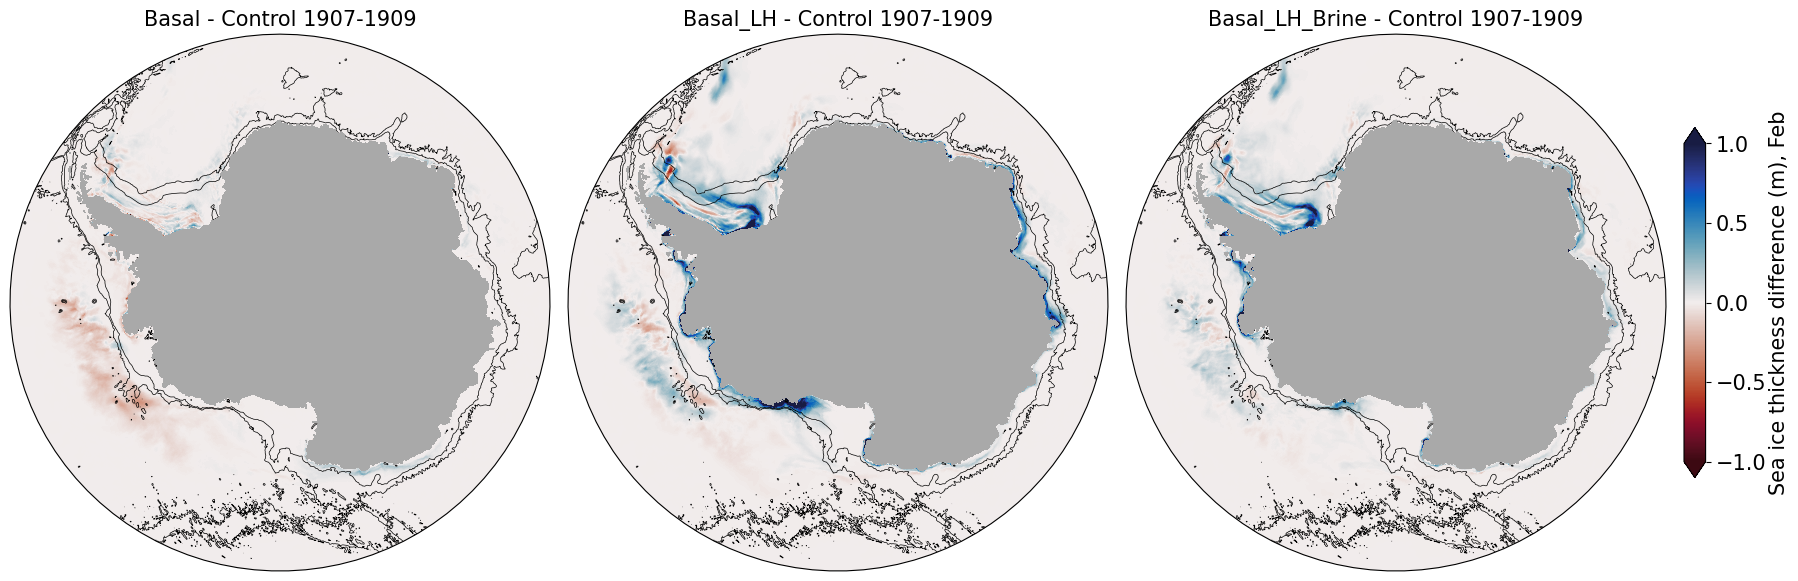

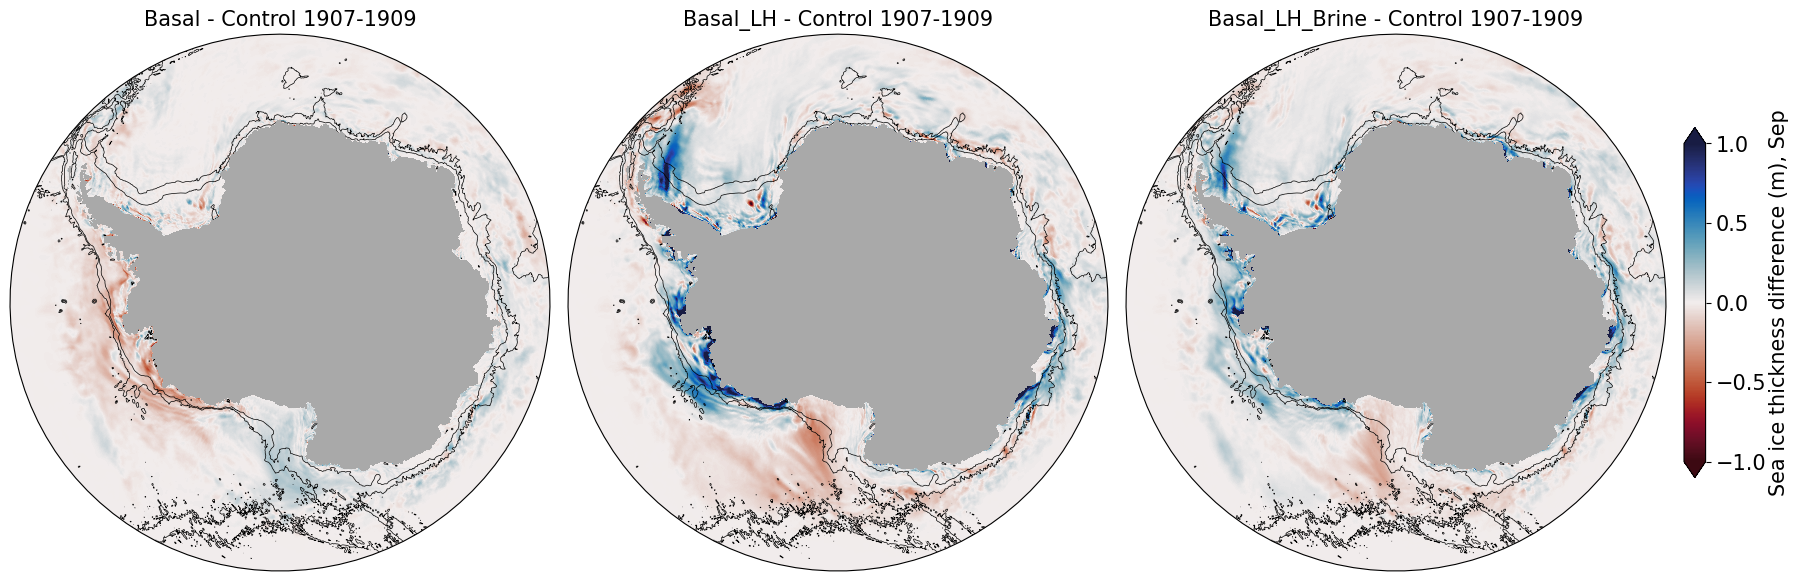

In [38]:
# Monthly climatological thickness differences from control **the only figs used in paper**

scale_max = 1

for m in months:
    fig  = plt.figure(figsize = (18,7))
    norm = col.Normalize(vmin=-scale_max, vmax=scale_max)
    
    for k in perturbations:
        ax = fig.add_axes(ax3[k], projection=ccrs.SouthPolarStereo())
        cf = plotmap(hi_mm[k].sel(month=m) - hi_mm['Control'].sel(month=m), f'{k} - Control {yearrange}')
    
    # colorbar:
    cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
    cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(r'Sea ice thickness difference (m), '+monthnames[m-1], fontsize=fontsize, labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)
    plt.savefig(f'SIT_{m}.png', dpi=200)

In [ ]:
# Monthly climatological SIC differences from control - not used in paper

scale_max = 0.2

for m in months:    
    fig  = plt.figure(figsize = (18,7))
    norm = col.Normalize(vmin=-scale_max, vmax=scale_max)

    for k in perturbations:
        ax = fig.add_axes(ax3[k], projection=ccrs.SouthPolarStereo())
        cf = plotmap(aice_mm[k].sel(month=m) - aice_mm['Control'].sel(month=m), f'{k} - Control {yearrange}')
    
    # colorbar:
    cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
    cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(r'Sea ice concentration difference, '+monthnames[m-1], fontsize=fontsize, labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

## Maps compared to obs _- not used in paper_

### Regridders
based on https://nbviewer.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb#Regridders

see https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Regridding.html and https://xesmf.readthedocs.io

In [ ]:
def G02202_obs_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a NSIDC G02202 NetCDF grid file
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)\
             .rename({'xgrid': 'x', 'ygrid': 'y',
                     'longitude': 'lon', 'latitude': 'lat'})
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-temp-1-daily-mean-ym_1958_01.nc')\
                    .rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        try:
            return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})
        except ValueError:
            return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean'})
    return outf

In [ ]:
obsfile_SH = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3/south/monthly/seaice_conc_monthly_sh_f08_198708_v03r01.nc'
regrid_SHobs_to_01 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_01.nc')

### Load observed sea ice concentration
based on https://nbviewer.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb

In [ ]:
def get_sic_obs(pattern, path='/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3', # from http://nsidc.org/data/G02202
                variable='goddard_merged_seaice_conc_monthly', timerange=obstimerange): 
    '''
    Return a dataarray from the nc files in path/pattern.
    '''
    dataarrays = []
    files = glob.glob(os.path.join(path, pattern))
    for f in tqdm_notebook(files, leave=False, desc='opening files'):
        dataarrays.append(xr.open_dataset(f, decode_times=False)[variable])
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units })

    # replace values outside valid range with nan
    dataarray = dataarray.where(np.logical_and(dataarray>=0, dataarray<=1)) #, np.nan)
    
    # use the same coord names as access-om2 t grid
    dataarray = dataarray.rename(({'xgrid': 'xt_ocean', 'ygrid': 'yt_ocean'}))
    
    # sort by time and select timerange
    dataarray = dataarray.sortby('time').sel(time=obstimerange)

    return dataarray

In [ ]:
def obs_mm(obs, groupby='time.month'):
    cobs = obs.groupby(groupby).mean('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

In [ ]:
obs_SH = get_sic_obs('south/monthly/*.nc', timerange=obstimerange)

In [ ]:
obs_SH_mm = obs_mm(obs_SH)  # monthly climatologies
obs_SH_avet = obs_SH.mean('time', skipna=True)  # mean for all data

In [ ]:
obs_SH_mm_regrid = regrid_SHobs_to_01(obs_SH_mm)
obs_SH_avet_regrid = regrid_SHobs_to_01(obs_SH_avet)

### plot SIC and SIC bias relative to obs (average over all months)

In [ ]:
ax4 = { k: d for k,d in zip(runs, [[0.0, 0.5, 0.45, 1], [0.46, 0.5, 0.45, 1], [0.0, 0.0, 0.45, 1], [0.46, 0.0, 0.45, 1]])}

In [ ]:
# Time-mean SIC

# TODO: need 5 panels here! need to include control....

fig  = plt.figure(1, figsize = (20, 20))
norm = col.Normalize(vmin=0, vmax=1)

ax = fig.add_axes(ax4['Control'],projection=ccrs.SouthPolarStereo())
cf = plotmap(obs_SH_avet_regrid, 'Obs (NOAA/NSIDC G02202v3, 1 May 1990 - 30 April 1991)', cmap=cmocean.ice)

for k in perturbations:
    ax = fig.add_axes(ax4[k], projection=ccrs.SouthPolarStereo())
    cf = plotmap(aice_avet[k], f'{k} ({yearrange})', cmap=cmocean.ice)

# colorbar:
cbaxes = fig.add_axes([0.93, 0.5, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice concentration', fontsize=fontsize, labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [ ]:
# Time-mean SIC biases

scale_max = 0.2

fig  = plt.figure(1, figsize = (20, 20))
norm = col.Normalize(vmin=-scale_max, vmax=scale_max)

for k in runs:
    ax = fig.add_axes(ax4[k], projection=ccrs.SouthPolarStereo())
    cf = plotmap(aice_avet[k] - obs_SH_avet_regrid, f'{k} ({yearrange}) - obs (1 May 1990 - 30 April 1991)')

# colorbar:
cbaxes = fig.add_axes([0.93, 0.5, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice concentration bias', fontsize=fontsize, labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### plot SIC and SIC bias relative to obs (climatology over one month)

In [ ]:
# Monthly SIC climatology

# TODO: need 5 panels here! need to include control....

for m in months:    

    fig  = plt.figure(figsize = (20, 20))
    norm = col.Normalize(vmin=0, vmax=1)
    
    ax = fig.add_axes(ax4['Control'],projection=ccrs.SouthPolarStereo())
    cf = plotmap(obs_SH_mm_regrid.sel(month=m), 'Obs (NOAA/NSIDC G02202v3, 1 May 1990 - 30 April 1991)', cmap=cmocean.ice)
    
    for k in perturbations:
        ax = fig.add_axes(ax4[k], projection=ccrs.SouthPolarStereo())
        cf = plotmap(aice_mm[k].sel(month=m), f'{k} ({yearrange})', cmap=cmocean.ice)
    
    # colorbar:
    cbaxes = fig.add_axes([0.93, 0.5, 0.012, 0.5])
    cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical')
    cbar.set_label(r'Sea ice concentration, '+monthnames[m-1], fontsize=fontsize, labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

In [ ]:
# Monthly SIC climatology biases

scale_max = 1

for m in months:    

    fig  = plt.figure(figsize = (20, 20))
    norm = col.Normalize(vmin=-scale_max, vmax=scale_max)

    obs = obs_SH_mm_regrid.sel(month=m).load()
    for k in runs:
        ax = fig.add_axes(ax4[k], projection=ccrs.SouthPolarStereo())
        cf = plotmap(aice_mm[k].sel(month=m) - obs, f'{k} ({yearrange}) - obs (1 May 1990 - 30 April 1991)')
    
    # colorbar:
    cbaxes = fig.add_axes([0.93, 0.5, 0.012, 0.5])
    cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical')
    cbar.set_label(r'Sea ice concentration bias, '+monthnames[m-1], fontsize=fontsize, labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

### SSS restoring (`sfc_salt_flux_restore`)

In [ ]:
# Monthly sfc_salt_flux_restore climatology

scale_max = 1e-6

for m in months:

    fig  = plt.figure(figsize = (20, 20))
    norm = col.Normalize(vmin=-scale_max, vmax=scale_max)
    
    for k in runs:
        ax = fig.add_axes(ax4[k], projection=ccrs.SouthPolarStereo())
        cf = plotmap(sfc_salt_flux_restore_mm[k].sel(month=m), f'{k} ({yearrange})')
    
    # colorbar:
    cbaxes = fig.add_axes([0.93, 0.5, 0.012, 0.5])
    cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical')
    cbar.set_label(r'Surface salt flux from SSS restoring [kg/m^2/s], '+monthnames[m-1], fontsize=fontsize, labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

In [ ]:
# Monthly sfc_salt_flux_restore climatology in Control

scale_max = 1e-6
fig  = plt.figure(figsize = (20, 20))
norm = col.Normalize(vmin=-scale_max, vmax=scale_max)

for i, m in enumerate([2, 5, 9, 12]):   
    for k in ['Control']:
        ax = fig.add_axes([ ax4[k] for k in runs ][i], projection=ccrs.SouthPolarStereo())
        cf = plotmap(sfc_salt_flux_restore_mm[k].sel(month=m), f'{k} ({yearrange}), {monthnames[m-1]}')

# colorbar:
cbaxes = fig.add_axes([0.93, 0.5, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical')
cbar.set_label(r'Surface salt flux from SSS restoring [kg/m^2/s]', fontsize=fontsize, labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)